In [10]:
from food.tools import *
from food.paths import *
from food.psql import *
import numpy as np
import torch
from torch.nn import CosineSimilarity
import requests
from food.qdrant import *
cos = CosineSimilarity(dim=1, eps=1e-08)
import pandas as pd

In [11]:
def search_image(url=None,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [12]:
collection_name = 'food_prompted'
table = 'foods_prompted'
foods = read_sql(table)
foods = foods.set_index('id')

In [13]:
foods = foods[foods['clip'].notna()]

In [14]:
text_to_vector = lambda text: torch.Tensor(requests.post(f'https://guru.skynet.center/text2vector/?text={text}').json())

In [15]:
drop_vector =      lambda clip, i: torch.cat([clip[0:i], clip[i+1:]])

def multiply_vector(clip,i,n=1):
    duplicated = torch.cat([clip[i].reshape(1,768) for _ in range(n)])
    return torch.cat([clip, duplicated.reshape(n,768)])

In [16]:
apple = 'https://image.shutterstock.com/image-photo/red-apple-isolated-on-white-600w-1728480094.jpg'
lunch = 'https://image.shutterstock.com/image-photo/plate-grilled-chicken-vegetables-on-600w-678630325.jpg'
orange ='https://image.shutterstock.com/image-photo/cut-whole-fresh-ripe-oranges-600w-1928412668.jpg'
burger = 'https://image.shutterstock.com/image-photo/hamburger-tomato-sauce-french-fries-600w-1912230376.jpg'

In [17]:

url = burger

def multiple_foods(url):

    image_clip,selected = search_image(url,head=100)
    selected=selected.reset_index(drop=True)
    clip = series2tensor(selected['clip'])
    initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

    startscore = initscore.detach().clone()-0.0000001

    while startscore !=initscore:
        startscore = initscore.detach().clone()
        
        selected = selected.reset_index(drop=True)
        for i in reversed(selected.index):
            clip = series2tensor(selected['clip'])
            dropped = drop_vector(clip,i)
            testscore = cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768))

            if testscore > initscore-0.0001: 
                r = selected.loc[i,'text']
                selected = selected.drop(i)
                initscore = testscore

            else:
                extra = multiply_vector(clip,i,1)
                testscore = cos(image_clip.reshape(1,768), extra.mean(0).reshape(1,768))
                if testscore > initscore: 
                    selected = selected.append(selected.loc[i])
                    initscore = testscore


            

        print(initscore)
    count = selected.groupby('text')['clip'].count().sort_index()
    r = selected.drop_duplicates('text').set_index("text").sort_index()
    r['count'] = count
    r = r.sort_values('count',ascending = False)
    r['cumcount'] = r['count'].cumsum()/r['count'].sum()

    description = '. '.join(r[r['cumcount']<0.9]['description'].unique().tolist())


    return r.drop(columns = ['clip']), description, selected

In [19]:
url

'https://image.shutterstock.com/image-photo/hamburger-tomato-sauce-french-fries-600w-1912230376.jpg'

In [18]:
search_image(url,head=1)[1]

,id,description,category,energy,protein,carb,fat,text,clip,score
0,1099797,"Hamburger, from school cafeteria",Burgers (single code),246.0,17.97,26.17,7.37,the food is burgers (single code) . it has a l...,"[0.04129654, -0.008462309, 0.023447905, 0.0058...",0.291915


In [10]:
url = 'https://image.shutterstock.com/image-photo/delicious-vegan-curry-dish-made-600w-1279830361.jpg'
r, desc, sel = multiple_foods(url)

/tmp/ipykernel_4160774/3908141632.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


tensor([0.3053], dtype=torch.float64)
tensor([0.3101], dtype=torch.float64)
tensor([0.3105], dtype=torch.float64)
tensor([0.3104], dtype=torch.float64)
tensor([0.3102], dtype=torch.float64)
tensor([0.3101], dtype=torch.float64)
tensor([0.3104], dtype=torch.float64)
tensor([0.3104], dtype=torch.float64)


In [15]:
desc

'Green peas, canned, cooked with butter or margarine. Green peas, fresh, cooked with butter or margarine. Papad, grilled or broiled. Beef stew with potatoes and vegetables excluding carrots, broccoli, and dark-green leafy; tomato-based sauce. Flowers or blossoms of sesbania, squash, or lily, cooked'

In [20]:
sel[['energy','protein','carb','fat']].mean().to_frame().T

,energy,protein,carb,fat
0,107.5,6.219,14.756,2.927


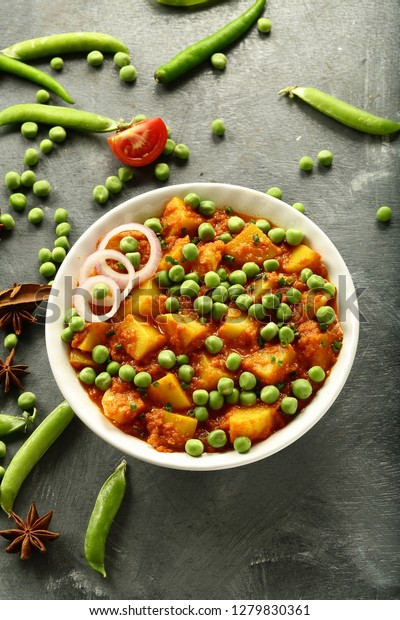

In [11]:
read_image_from_url(url)

In [12]:
r

,id,description,category,energy,protein,carb,fat,score,count,cumcount
text,,,,,,,,,,
the food is other starchy vegetables . it has a little bit of cooked with butter or margarine canned green peas,1103556,"Green peas, canned, cooked with butter or marg...",Other starchy vegetables,85.0,4.36,11.04,2.95,0.299859,3,0.3
the food is other starchy vegetables . it has a little bit of cooked with butter or margarine fresh green peas,1103552,"Green peas, fresh, cooked with butter or marga...",Other starchy vegetables,102.0,5.48,14.58,2.66,0.298348,2,0.5
"the food is beans, peas, legumes . it has a little bit of grilled or broiled papad",1100443,"Papad, grilled or broiled","Beans, peas, legumes",371.0,25.56,59.87,3.25,0.273562,1,0.6
the food is meat mixed dishes . it has a little bit of and dark-green leafy; tomato-based sauce broccoli beef stew with potatoes and vegetables excluding carrots,1099430,Beef stew with potatoes and vegetables excludi...,Meat mixed dishes,82.0,6.64,8.48,2.36,0.251240,1,0.7
the food is other vegetables and combinations . it has a little bit of cooked or lily squash flowers or blossoms of sesbania,1103515,"Flowers or blossoms of sesbania, squash, or li...",Other vegetables and combinations,37.0,1.06,3.20,2.61,0.245910,1,0.8
the food is other vegetables and combinations . it has a little bit of cooked bitter melon,1103462,"Bitter melon, cooked",Other vegetables and combinations,41.0,0.82,4.19,2.71,0.252503,1,0.9
the food is vegetable dishes . it has a little bit of channa saag,1103154,Channa Saag,Vegetable dishes,85.0,4.07,9.54,4.17,0.247463,1,1.0


In [13]:
nutrition = energy.to_frame().T

NameError: name 'energy' is not defined

In [286]:
classes[['description','category','count']].reset_index(drop=True)

,description,category,count
0,Corn nuts,"Tortilla, corn, other chips",4
1,"Lima beans and corn, cooked, fat added",Other starchy vegetables,3
2,"Seven-layer salad, lettuce salad made with a c...",Vegetable dishes,3
3,"Cactus, cooked, fat added",Other vegetables and combinations,2
4,Black bean salad,"Bean, pea, legume dishes",1


In [287]:
'. '.join(classes[classes['cumcount']<0.9]['description'].unique().tolist())

'Corn nuts. Lima beans and corn, cooked, fat added. Seven-layer salad, lettuce salad made with a combination of onion, celery, green pepper, peas, mayonnaise, cheese, eggs, and/or bacon'

In [282]:
url

'https://image.shutterstock.com/image-photo/healhty-vegan-lunch-bowl-avocado-600w-753381028.jpg'

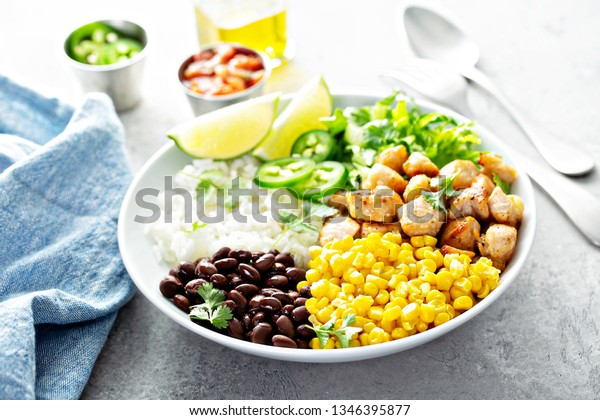

In [304]:
read_image_from_url(url)